In [1]:
import numpy as np
from utils.bootstrap_corr import *
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import statsmodels.sandbox.stats.multicomp as mc
import seaborn as sns
plt.style.use("ggplot")
sns.set_style('whitegrid')
plt.rcParams["font.family"] = "Arial"
import nibabel as nib
import pandas as pd
import h5py
from importlib import reload
import os
from brainsmash.mapgen.base import Base
from brainsmash.mapgen.stats import pearsonr, pairwise_r

## Set-up parameters

In [2]:
## General parameters/variables 
nParcels = 360

glasserfile2 = '../resultdata/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

color1, color2 = sns.color_palette(palette='pastel',n_colors=2)

# Import network partition
networkdef = np.loadtxt('../resultdata/network_partition.txt')
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()
 
associationnets = ['con','dan','lan','fpn','dmn','pmulti','none1','none2']
sensorimotornets = ['vis1','vis2','smn','aud']

roi_id = np.zeros((nParcels,))
tmp = {}
netcount = 0
for network in networkmappings:
    net = np.where(networkdef==networkmappings[network])[0]
    for roi in net:
        if network in associationnets:
            tmp[roi] = color1 #'r'
            roi_id[roi] = -1
        else:
            tmp[roi] = color2 #'b'
            roi_id[roi] = 1
    netcount += 1
    
roiColorsByNetwork = []
for roi in range(len(networkdef)):
    roiColorsByNetwork.append(tmp[roi])

/Users/tito/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """


# Load in data

In [3]:
resultdir = '../resultdata/'

#### Load time scale data
taus_rest = np.loadtxt(resultdir + 'timescales/Murray_taus_regions_autocorrelation_rest100.txt',delimiter=',')
bad_ind = np.where(taus_rest>50)
taus_rest[bad_ind] = np.nan

#### Load in myelin data
myelinmap = np.squeeze(nib.load(resultdir + 'Mean.339.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii').get_data())
nvertices = int(glasser2.shape[0]/2)
glasser_lr = np.hstack((glasser2[nvertices:],glasser2[:nvertices])) # need to flip this original parcellation
myelinmap_parc = np.zeros((nParcels,))
for roi in range(nParcels):
    roi_ind = np.where(glasser_lr==roi+1)[0]
    myelinmap_parc[roi] = np.mean(myelinmap[roi_ind])

#### Load in Margulies gradient data
# RH
gradient_rh = np.squeeze(nib.load(resultdir + 'margulies2016/hcp.tmp.rh.dscalar.nii').get_data())
# Remove all the '0s' in the array
nonzero_ind = np.where(gradient_rh!=0)[0]
gradient_rh = gradient_rh[nonzero_ind].copy()
# LH
gradient_lh = np.squeeze(nib.load(resultdir + 'margulies2016/hcp.tmp.lh.dscalar.nii').get_data())
# Remove all the '0s' in the array
nonzero_ind = np.where(gradient_lh!=0)[0]
gradient_lh = gradient_lh[nonzero_ind].copy()
# Glasser atlas is orgnized R->L hemispheres
gradient = np.hstack((gradient_lh,gradient_rh))
# Parcellate
gradient_parcellated = np.zeros((nParcels,))
for roi in range(nParcels):
    roi_ind = np.where(glasser2==roi+1)[0]
    gradient_parcellated[roi] = np.mean(gradient[roi_ind])

#### Load in canonical HRF task activations GLM
t_act = np.loadtxt(resultdir + 'activity/activity_canonicalHRF.csv',delimiter=',')
t_act = np.mean(t_act,axis=1)

#### Load in FIR based task FC
fcchange = np.loadtxt(resultdir + 'connectivity/conn_taskVrest_gbc_FIR_posOnly.csv', delimiter=',')


/Users/tito/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
/Users/tito/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
/Users/tito/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarn

#### Correlate activity x FC (positive values only)

Spearman True: -0.25407397690825806 | CI = ( -0.3529988978470078 , -0.15409896278295324 )
Pearson True: -0.22629260522848163 | CI = ( -0.30881420887086236 , -0.12724062185069357 )


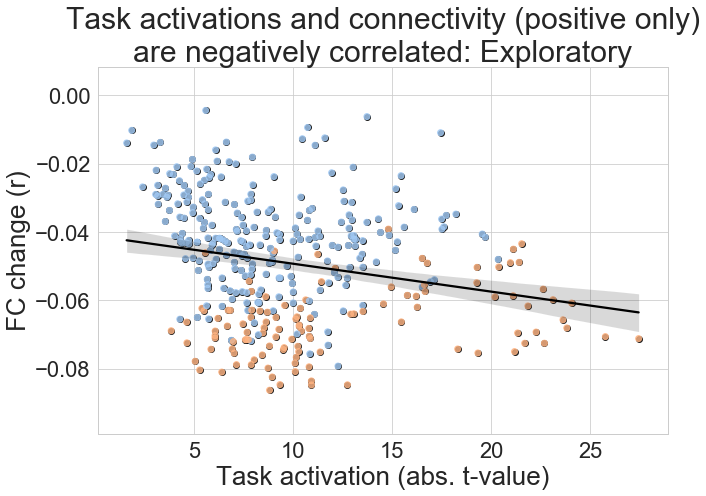

In [4]:
r, lower_ci, upper_ci = bootstrap_corr(t_act,np.mean(fcchange,axis=1),corr_type='spearman')
print('Spearman True:', r, '| CI = (', lower_ci, ',', upper_ci,')')
#
r, lower_ci, upper_ci = bootstrap_corr(t_act,np.mean(fcchange,axis=1),corr_type='pearson')
print('Pearson True:', r, '| CI = (', lower_ci, ',', upper_ci,')')

plt.figure(figsize=(10,7))
sns.regplot(t_act,np.mean(fcchange,axis=1),color='k',fit_reg=False)
sns.regplot(t_act,np.mean(fcchange,axis=1),color='k',scatter_kws={'color':roiColorsByNetwork})
plt.ylabel('FC change (r)',fontsize=26)
plt.xlabel('Task activation (abs. t-value)',fontsize=26)
plt.title('Task activations and connectivity (positive only)\nare negatively correlated: Exploratory',fontsize=30)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
# plt.savefig('SFig_ActivityXConnectivity_Univariate_PosOnly.pdf')

___
# Compute surrogate maps using BrainSMASH

In [4]:
geo_dist_rh = np.loadtxt(resultdir + 'BrainSMASH_GeoDesicDistances/RightParcelGeodesicDistmat.txt')
geo_dist_lh = np.loadtxt(resultdir + 'BrainSMASH_GeoDesicDistances/LeftParcelGeodesicDistmat.txt')
n_surrogates = 1000

print('Generate surrogate maps for task activity')
base = Base(t_act[:180],geo_dist_lh)
surrogates_lh = base(n=n_surrogates)
base = Base(t_act[180:],geo_dist_rh)
surrogates_rh = base(n=n_surrogates)
surrogates_tact = np.hstack((surrogates_lh,surrogates_rh))

print('Generate surrogate maps for FC change')
base = Base(np.mean(fcchange,axis=1)[:180],geo_dist_lh)
surrogates_lh = base(n=n_surrogates)
base = Base(np.mean(fcchange,axis=1)[180:],geo_dist_rh)
surrogates_rh = base(n=n_surrogates)
surrogates_fc = np.hstack((surrogates_lh,surrogates_rh))

print('Generate surrogate maps for myelin map')
base = Base(myelinmap_parc[:180],geo_dist_lh)
surrogates_lh = base(n=n_surrogates)
base = Base(myelinmap_parc[180:],geo_dist_rh)
surrogates_rh = base(n=n_surrogates)
surrogates_myelin = np.hstack((surrogates_lh,surrogates_rh))

print('Generate surrogate maps for timescale map')
base = Base(np.nanmean(taus_rest,axis=1)[:180],geo_dist_lh)
surrogates_lh = base(n=n_surrogates)
base = Base(np.nanmean(taus_rest,axis=1)[180:],geo_dist_rh)
surrogates_rh = base(n=n_surrogates)
surrogates_timescale = np.hstack((surrogates_lh,surrogates_rh))

print('Generate surrogate maps for principal gradient')
base = Base(gradient_parcellated[:180],geo_dist_lh)
surrogates_lh = base(n=n_surrogates)
base = Base(gradient_parcellated[180:],geo_dist_rh)
surrogates_rh = base(n=n_surrogates)
surrogates_gradient = np.hstack((surrogates_lh,surrogates_rh))

Generate surrogate maps for task activity
Generate surrogate maps for FC change
Generate surrogate maps for myelin map
Generate surrogate maps for timescale map
Generate surrogate maps for principal gradient


# Compute null distribution p-values with correct SA -- regular FC/activity estimates
#### Using Spearman's rank correlation

Maximum FDR-corrected q: 0.006


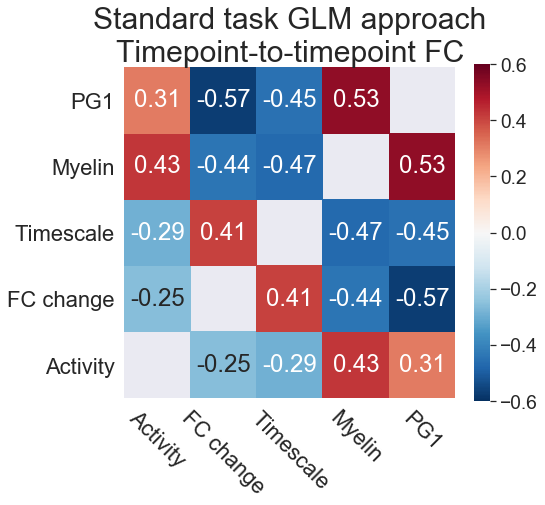

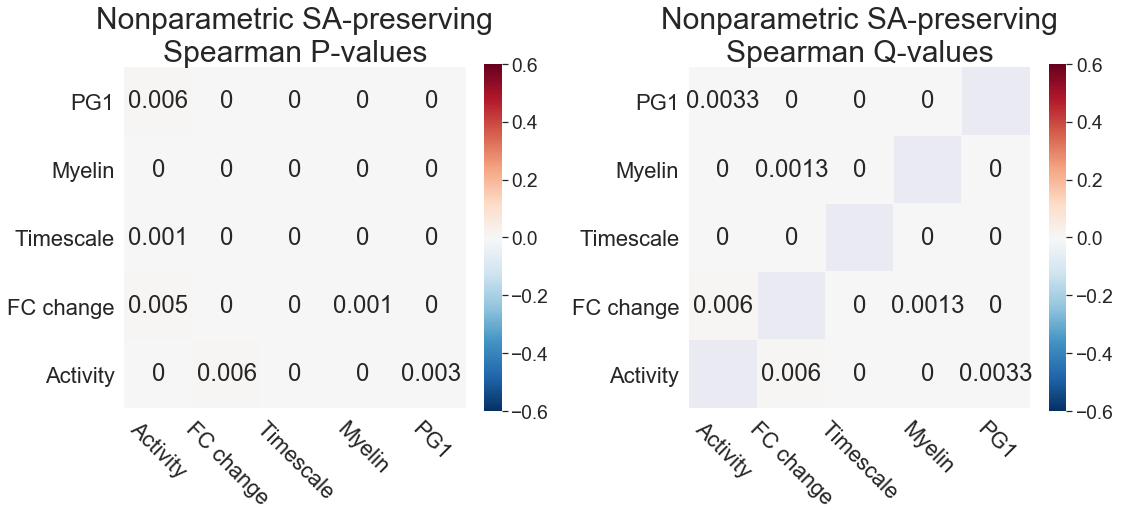

In [5]:
labels = ['Activity','FC change','Timescale','Myelin','PG1']
corrmat = np.zeros((5,5))
pmat = np.zeros((5,5))
#### For activity
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_tact[i],np.mean(fcchange,axis=1))[0] 
test_stat = stats.spearmanr(t_act,np.mean(fcchange,axis=1))[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[0,1], pmat[0,1] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_tact[i],np.nanmean(taus_rest,axis=1))[0] 
test_stat = stats.spearmanr(t_act,np.nanmean(taus_rest,axis=1))[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[0,2], pmat[0,2] = test_stat, pval 
# 
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_tact[i],myelinmap_parc)[0] 
test_stat = stats.spearmanr(t_act,myelinmap_parc)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[0,3], pmat[0,3] = test_stat, pval 
# 
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_tact[i],gradient_parcellated)[0] 
test_stat = stats.spearmanr(t_act,gradient_parcellated)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[0,4], pmat[0,4] = test_stat, pval 
# 
#### For FC
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_fc[i],t_act)[0] 
test_stat = stats.spearmanr(np.mean(fcchange,axis=1),t_act)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[1,0], pmat[1,0] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_fc[i],np.nanmean(taus_rest,axis=1))[0] 
test_stat = stats.spearmanr(np.mean(fcchange,axis=1),np.nanmean(taus_rest,axis=1))[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[1,2], pmat[1,2] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_fc[i],myelinmap_parc)[0] 
test_stat = stats.spearmanr(np.mean(fcchange,axis=1),myelinmap_parc)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[1,3], pmat[1,3] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_fc[i],gradient_parcellated)[0] 
test_stat = stats.spearmanr(np.mean(fcchange,axis=1),gradient_parcellated)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[1,4], pmat[1,4] = test_stat, pval
#
#### For timescale
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_timescale[i],t_act)[0] 
test_stat = stats.spearmanr(np.nanmean(taus_rest,axis=1),t_act)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[2,0], pmat[2,0] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_timescale[i],np.mean(fcchange,axis=1))[0] 
test_stat = stats.spearmanr(np.nanmean(taus_rest,axis=1),np.mean(fcchange,axis=1))[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[2,1], pmat[2,1] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_timescale[i],myelinmap_parc)[0] 
test_stat = stats.spearmanr(np.nanmean(taus_rest,axis=1),myelinmap_parc)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[2,3], pmat[2,3] = test_stat, pval
# 
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_timescale[i],gradient_parcellated)[0] 
test_stat = stats.spearmanr(np.nanmean(taus_rest,axis=1),gradient_parcellated)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[2,4], pmat[2,4] = test_stat, pval
#
#### For myelin map
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_myelin[i],t_act)[0] 
test_stat = stats.spearmanr(myelinmap_parc,t_act)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[3,0], pmat[3,0] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_myelin[i],np.mean(fcchange,axis=1))[0] 
test_stat = stats.spearmanr(myelinmap_parc,np.mean(fcchange,axis=1))[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[3,1], pmat[3,1] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_myelin[i],np.nanmean(taus_rest,axis=1))[0] 
test_stat = stats.spearmanr(myelinmap_parc,np.nanmean(taus_rest,axis=1))[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[3,2], pmat[3,2] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_myelin[i],gradient_parcellated)[0] 
test_stat = stats.spearmanr(myelinmap_parc,gradient_parcellated)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[3,4], pmat[3,4] = test_stat, pval
#
#### For principal gradient
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_gradient[i],t_act)[0] 
test_stat = stats.spearmanr(gradient_parcellated,t_act)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[4,0], pmat[4,0] = test_stat, pval
# 
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_gradient[i],np.mean(fcchange,axis=1))[0] 
test_stat = stats.spearmanr(gradient_parcellated,np.mean(fcchange,axis=1))[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[4,1], pmat[4,1] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_gradient[i],np.nanmean(taus_rest,axis=1))[0] 
test_stat = stats.spearmanr(gradient_parcellated,np.nanmean(taus_rest,axis=1))[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[4,2], pmat[4,2] = test_stat, pval
# 
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_gradient[i],myelinmap_parc)[0] 
test_stat = stats.spearmanr(gradient_parcellated,myelinmap_parc)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[4,3], pmat[4,3] = test_stat, pval
np.fill_diagonal(corrmat,np.nan)

ind = [0,1,2,3,4]
labels = np.asarray(labels)[ind]

ind = np.asarray(ind,dtype=int)
ind.shape = (len(ind),1)
plt.figure(figsize=(8,8))
sns.set(font_scale=1.75)
ax = sns.heatmap(corrmat[ind,ind.T],square=True,center=0,vmin=-0.6,vmax=0.6,
                 cmap='RdBu_r',cbar_kws={'fraction':0.046},
                 annot=True,annot_kws={"size": 24})
ax.invert_yaxis()
plt.title('Standard task GLM approach\nTimepoint-to-timepoint FC',fontname='Arial',fontsize=30)
plt.xticks(np.arange(0.5,5.5),labels,fontsize=22,rotation=-45)
plt.yticks(np.arange(0.5,5.5),labels,fontsize=22,rotation=0)
plt.tight_layout()
# plt.savefig('SFig_SummaryFigure_TaskGLM_Spearman_PosOnlyFC.pdf')


plt.figure(figsize=(16,8))
sns.set(font_scale=1.75)
plt.subplot(121)
ax = sns.heatmap(pmat[ind,ind.T],square=True,center=0,vmin=-0.6,vmax=0.6,
                 cmap='RdBu_r',cbar_kws={'fraction':0.046},
                 annot=True,annot_kws={"size": 24})
ax.invert_yaxis()
plt.title('Nonparametric SA-preserving\nSpearman P-values',fontname='Arial',fontsize=30)
plt.xticks(np.arange(0.5,5.5),labels,fontsize=22,rotation=-45)
plt.yticks(np.arange(0.5,5.5),labels,fontsize=22,rotation=0)
plt.tight_layout()
# compute fdr-corrected q-values
triu_ind = np.triu_indices(5,1)

plt.subplot(122)
qmat = np.zeros(pmat.shape)
qmat[triu_ind] = mc.fdrcorrection0(pmat[triu_ind])[1]
qmat = qmat + qmat.T
np.fill_diagonal(qmat,np.nan)
ax = sns.heatmap(qmat[ind,ind.T],square=True,center=0,vmin=-0.6,vmax=0.6,
                 cmap='RdBu_r',cbar_kws={'fraction':0.046},
                 annot=True,annot_kws={"size": 24})
ax.invert_yaxis()
plt.title('Nonparametric SA-preserving\nSpearman Q-values',fontname='Arial',fontsize=30)
plt.xticks(np.arange(0.5,5.5),labels,fontsize=22,rotation=-45)
plt.yticks(np.arange(0.5,5.5),labels,fontsize=22,rotation=0)
plt.tight_layout()
# compute fdr-corrected q-values
triu_ind = np.triu_indices(5,1)

qarr = mc.fdrcorrection0(pmat[triu_ind])[1]
print('Maximum FDR-corrected q:', np.max(qarr))

___

# Load in data - REPLICATION

In [5]:
resultdir = '../resultdata/'

#### Load time scale data
taus_rest_rep = np.loadtxt(resultdir + 'timescales/Murray_taus_regions_autocorrelation_rest100_replication.txt',delimiter=',')
bad_ind = np.where(taus_rest>50)
taus_rest[bad_ind] = np.nan
# bad_ind = np.where(taus_rest<0)
# taus_rest[bad_ind] = np.nan

#### Load in myelin data
myelinmap = np.squeeze(nib.load(resultdir + 'Mean.339.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii').get_data())
nvertices = int(glasser2.shape[0]/2)
glasser_lr = np.hstack((glasser2[nvertices:],glasser2[:nvertices])) # need to flip this original parcellation
myelinmap_parc = np.zeros((nParcels,))
for roi in range(nParcels):
    roi_ind = np.where(glasser_lr==roi+1)[0]
    myelinmap_parc[roi] = np.mean(myelinmap[roi_ind])

#### Load in Margulies gradient data
# RH
gradient_rh = np.squeeze(nib.load(resultdir + 'margulies2016/hcp.tmp.rh.dscalar.nii').get_data())
# Remove all the '0s' in the array
nonzero_ind = np.where(gradient_rh!=0)[0]
gradient_rh = gradient_rh[nonzero_ind].copy()
# LH
gradient_lh = np.squeeze(nib.load(resultdir + 'margulies2016/hcp.tmp.lh.dscalar.nii').get_data())
# Remove all the '0s' in the array
nonzero_ind = np.where(gradient_lh!=0)[0]
gradient_lh = gradient_lh[nonzero_ind].copy()
# Glasser atlas is orgnized R->L hemispheres
gradient = np.hstack((gradient_lh,gradient_rh))
# Parcellate
gradient_parcellated = np.zeros((nParcels,))
for roi in range(nParcels):
    roi_ind = np.where(glasser2==roi+1)[0]
    gradient_parcellated[roi] = np.mean(gradient[roi_ind])

#### Load in canonical HRF task activations GLM
t_act_rep = np.loadtxt(resultdir + 'activity/activity_canonicalHRF_replication.csv',delimiter=',')
t_act_rep = np.mean(t_act_rep,axis=1)

#### Load in FIR based task FC
fcchange_rep = np.loadtxt(resultdir + 'connectivity/conn_taskVrest_gbc_replication_FIR_posOnly.csv', delimiter=',')


/Users/tito/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/Users/tito/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # This is added back by InteractiveShellApp.init_path()
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
/Users/tito/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> 

#### Correlate activity x FC (positive values only)

Spearman True: -0.25132678492889604 | CI = ( -0.3442743545236044 , -0.15460680896836626 )
Pearson True: -0.234210828928269 | CI = ( -0.3218523391424395 , -0.13779260202697213 )


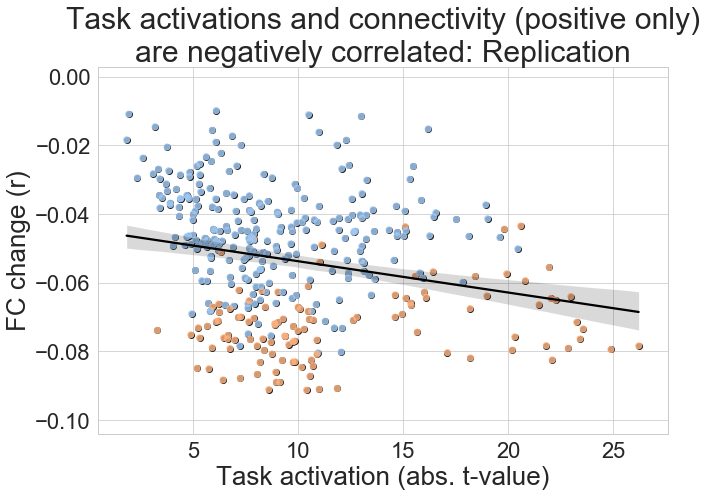

In [6]:
r, lower_ci, upper_ci = bootstrap_corr(t_act_rep,np.mean(fcchange_rep,axis=1),corr_type='spearman')
print('Spearman True:', r, '| CI = (', lower_ci, ',', upper_ci,')')
#
r, lower_ci, upper_ci = bootstrap_corr(t_act_rep,np.mean(fcchange_rep,axis=1),corr_type='pearson')
print('Pearson True:', r, '| CI = (', lower_ci, ',', upper_ci,')')

plt.figure(figsize=(10,7))
sns.regplot(t_act_rep,np.mean(fcchange_rep,axis=1),color='k',fit_reg=False)
sns.regplot(t_act_rep,np.mean(fcchange_rep,axis=1),color='k',scatter_kws={'color':roiColorsByNetwork})
plt.ylabel('FC change (r)',fontsize=26)
plt.xlabel('Task activation (abs. t-value)',fontsize=26)
plt.title('Task activations and connectivity (positive only)\nare negatively correlated: Replication',fontsize=30)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
# plt.savefig('SFig_ActivityXConnectivity_Univariate_PosOnly_Replication.pdf')

___
# Compute surrogate maps using BrainSMASH

In [7]:
geo_dist_rh = np.loadtxt(resultdir + 'BrainSMASH_GeoDesicDistances/RightParcelGeodesicDistmat.txt')
geo_dist_lh = np.loadtxt(resultdir + 'BrainSMASH_GeoDesicDistances/LeftParcelGeodesicDistmat.txt')
n_surrogates = 1000

print('Generate surrogate maps for task activity')
base = Base(t_act_rep[:180],geo_dist_lh)
surrogates_lh = base(n=n_surrogates)
base = Base(t_act_rep[180:],geo_dist_rh)
surrogates_rh = base(n=n_surrogates)
surrogates_tact = np.hstack((surrogates_lh,surrogates_rh))

print('Generate surrogate maps for FC change')
base = Base(np.mean(fcchange_rep,axis=1)[:180],geo_dist_lh)
surrogates_lh = base(n=n_surrogates)
base = Base(np.mean(fcchange_rep,axis=1)[180:],geo_dist_rh)
surrogates_rh = base(n=n_surrogates)
surrogates_fc = np.hstack((surrogates_lh,surrogates_rh))

print('Generate surrogate maps for myelin map')
base = Base(myelinmap_parc[:180],geo_dist_lh)
surrogates_lh = base(n=n_surrogates)
base = Base(myelinmap_parc[180:],geo_dist_rh)
surrogates_rh = base(n=n_surrogates)
surrogates_myelin = np.hstack((surrogates_lh,surrogates_rh))

print('Generate surrogate maps for timescale map')
base = Base(np.nanmean(taus_rest_rep,axis=1)[:180],geo_dist_lh)
surrogates_lh = base(n=n_surrogates)
base = Base(np.nanmean(taus_rest_rep,axis=1)[180:],geo_dist_rh)
surrogates_rh = base(n=n_surrogates)
surrogates_timescale = np.hstack((surrogates_lh,surrogates_rh))

print('Generate surrogate maps for principal gradient')
base = Base(gradient_parcellated[:180],geo_dist_lh)
surrogates_lh = base(n=n_surrogates)
base = Base(gradient_parcellated[180:],geo_dist_rh)
surrogates_rh = base(n=n_surrogates)
surrogates_gradient = np.hstack((surrogates_lh,surrogates_rh))

Generate surrogate maps for task activity
Generate surrogate maps for FC change
Generate surrogate maps for myelin map
Generate surrogate maps for timescale map
Generate surrogate maps for principal gradient


# Compute null distribution p-values with correct SA -- regular FC/activity estimates
#### Using Spearman's rank correlation

Maximum FDR-corrected q: 0.003


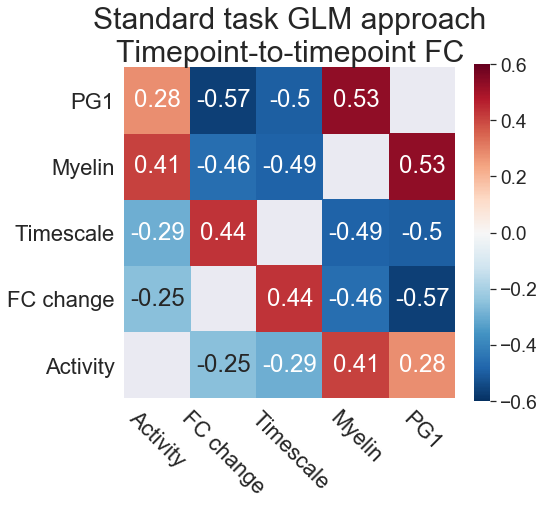

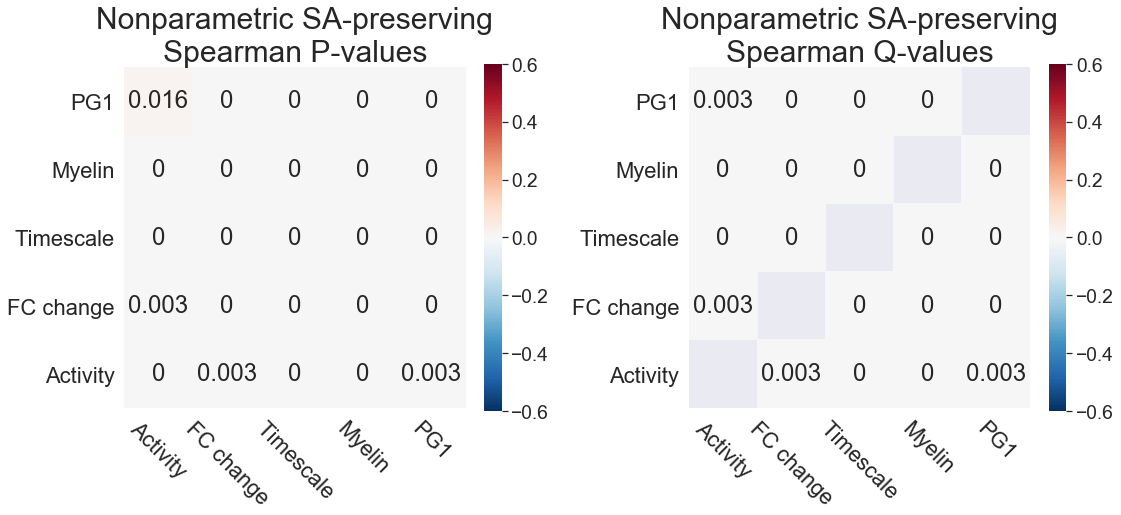

In [8]:
labels = ['Activity','FC change','Timescale','Myelin','PG1']
corrmat = np.zeros((5,5))
pmat = np.zeros((5,5))
#### For activity
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_tact[i],np.mean(fcchange_rep,axis=1))[0] 
test_stat = stats.spearmanr(t_act_rep,np.mean(fcchange_rep,axis=1))[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[0,1], pmat[0,1] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_tact[i],np.nanmean(taus_rest_rep,axis=1))[0] 
test_stat = stats.spearmanr(t_act_rep,np.nanmean(taus_rest_rep,axis=1))[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[0,2], pmat[0,2] = test_stat, pval 
# 
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_tact[i],myelinmap_parc)[0] 
test_stat = stats.spearmanr(t_act_rep,myelinmap_parc)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[0,3], pmat[0,3] = test_stat, pval 
# 
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_tact[i],gradient_parcellated)[0] 
test_stat = stats.spearmanr(t_act_rep,gradient_parcellated)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[0,4], pmat[0,4] = test_stat, pval 
# 
#### For FC
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_fc[i],t_act_rep)[0] 
test_stat = stats.spearmanr(np.mean(fcchange_rep,axis=1),t_act_rep)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[1,0], pmat[1,0] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_fc[i],np.nanmean(taus_rest_rep,axis=1))[0] 
test_stat = stats.spearmanr(np.mean(fcchange_rep,axis=1),np.nanmean(taus_rest_rep,axis=1))[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[1,2], pmat[1,2] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_fc[i],myelinmap_parc)[0] 
test_stat = stats.spearmanr(np.mean(fcchange_rep,axis=1),myelinmap_parc)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[1,3], pmat[1,3] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_fc[i],gradient_parcellated)[0] 
test_stat = stats.spearmanr(np.mean(fcchange_rep,axis=1),gradient_parcellated)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[1,4], pmat[1,4] = test_stat, pval
#
#### For timescale
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_timescale[i],t_act_rep)[0] 
test_stat = stats.spearmanr(np.nanmean(taus_rest_rep,axis=1),t_act_rep)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[2,0], pmat[2,0] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_timescale[i],np.mean(fcchange_rep,axis=1))[0] 
test_stat = stats.spearmanr(np.nanmean(taus_rest_rep,axis=1),np.mean(fcchange_rep,axis=1))[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[2,1], pmat[2,1] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_timescale[i],myelinmap_parc)[0] 
test_stat = stats.spearmanr(np.nanmean(taus_rest_rep,axis=1),myelinmap_parc)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[2,3], pmat[2,3] = test_stat, pval
# 
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_timescale[i],gradient_parcellated)[0] 
test_stat = stats.spearmanr(np.nanmean(taus_rest_rep,axis=1),gradient_parcellated)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[2,4], pmat[2,4] = test_stat, pval
#
#### For myelin map
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_myelin[i],t_act_rep)[0] 
test_stat = stats.spearmanr(myelinmap_parc,t_act_rep)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[3,0], pmat[3,0] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_myelin[i],np.mean(fcchange_rep,axis=1))[0] 
test_stat = stats.spearmanr(myelinmap_parc,np.mean(fcchange_rep,axis=1))[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[3,1], pmat[3,1] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_myelin[i],np.nanmean(taus_rest_rep,axis=1))[0] 
test_stat = stats.spearmanr(myelinmap_parc,np.nanmean(taus_rest_rep,axis=1))[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[3,2], pmat[3,2] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_myelin[i],gradient_parcellated)[0] 
test_stat = stats.spearmanr(myelinmap_parc,gradient_parcellated)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[3,4], pmat[3,4] = test_stat, pval
#
#### For principal gradient
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_gradient[i],t_act_rep)[0] 
test_stat = stats.spearmanr(gradient_parcellated,t_act_rep)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[4,0], pmat[4,0] = test_stat, pval
# 
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_gradient[i],np.mean(fcchange_rep,axis=1))[0] 
test_stat = stats.spearmanr(gradient_parcellated,np.mean(fcchange_rep,axis=1))[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[4,1], pmat[4,1] = test_stat, pval
#
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_gradient[i],np.nanmean(taus_rest_rep,axis=1))[0] 
test_stat = stats.spearmanr(gradient_parcellated,np.nanmean(taus_rest_rep,axis=1))[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[4,2], pmat[4,2] = test_stat, pval
# 
surrogate_brainmap_corrs = np.zeros((n_surrogates,))
for i in range(n_surrogates): surrogate_brainmap_corrs[i] = stats.spearmanr(surrogates_gradient[i],myelinmap_parc)[0] 
test_stat = stats.spearmanr(gradient_parcellated,myelinmap_parc)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
corrmat[4,3], pmat[4,3] = test_stat, pval
np.fill_diagonal(corrmat,np.nan)

ind = [0,1,2,3,4]
labels = np.asarray(labels)[ind]

ind = np.asarray(ind,dtype=int)
ind.shape = (len(ind),1)
plt.figure(figsize=(8,8))
sns.set(font_scale=1.75)
ax = sns.heatmap(corrmat[ind,ind.T],square=True,center=0,vmin=-0.6,vmax=0.6,
                 cmap='RdBu_r',cbar_kws={'fraction':0.046},
                 annot=True,annot_kws={"size": 24})
ax.invert_yaxis()
plt.title('Standard task GLM approach\nTimepoint-to-timepoint FC',fontname='Arial',fontsize=30)
plt.xticks(np.arange(0.5,5.5),labels,fontsize=22,rotation=-45)
plt.yticks(np.arange(0.5,5.5),labels,fontsize=22,rotation=0)
plt.tight_layout()
# plt.savefig('SFig_SummaryFigure_TaskGLM_Spearman_PosOnlyFC_replication.pdf')


plt.figure(figsize=(16,8))
sns.set(font_scale=1.75)
plt.subplot(121)
ax = sns.heatmap(pmat[ind,ind.T],square=True,center=0,vmin=-0.6,vmax=0.6,
                 cmap='RdBu_r',cbar_kws={'fraction':0.046},
                 annot=True,annot_kws={"size": 24})
ax.invert_yaxis()
plt.title('Nonparametric SA-preserving\nSpearman P-values',fontname='Arial',fontsize=30)
plt.xticks(np.arange(0.5,5.5),labels,fontsize=22,rotation=-45)
plt.yticks(np.arange(0.5,5.5),labels,fontsize=22,rotation=0)
plt.tight_layout()
# compute fdr-corrected q-values
triu_ind = np.triu_indices(5,1)

plt.subplot(122)
qmat = np.zeros(pmat.shape)
qmat[triu_ind] = mc.fdrcorrection0(pmat[triu_ind])[1]
qmat = qmat + qmat.T
np.fill_diagonal(qmat,np.nan)
ax = sns.heatmap(qmat[ind,ind.T],square=True,center=0,vmin=-0.6,vmax=0.6,
                 cmap='RdBu_r',cbar_kws={'fraction':0.046},
                 annot=True,annot_kws={"size": 24})
ax.invert_yaxis()
plt.title('Nonparametric SA-preserving\nSpearman Q-values',fontname='Arial',fontsize=30)
plt.xticks(np.arange(0.5,5.5),labels,fontsize=22,rotation=-45)
plt.yticks(np.arange(0.5,5.5),labels,fontsize=22,rotation=0)
plt.tight_layout()
# compute fdr-corrected q-values
triu_ind = np.triu_indices(5,1)

qarr = mc.fdrcorrection0(pmat[triu_ind])[1]
print('Maximum FDR-corrected q:', np.max(qarr))

# Map back to surface

In [30]:
# riodata = np.zeros((glasser2.shape[0],2)) 

# tmp_con = np.mean(fcchange,axis=1)
# tmp_con_rep = np.mean(fcchange_rep,axis=1)

# for roi in range(nParcels):
#     roi_ind = np.where(glasser2==roi+1)[0]
    
#     riodata[roi_ind,0] = tmp_con[roi]
#     riodata[roi_ind,1] = tmp_con_rep[roi]
    
# # Compute effect size baseline (information content)
# filename = 'FCChange_POSONLY'
# np.savetxt(filename + '.csv', riodata,fmt='%s')
# wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + filename + '.dscalar.nii -reset-scalars'
# os.system(wb_command)

0